# Clustering Time Series using MPdist

This tutorial replicates figure 5 from [Matrix Profile XII](https://ueaeprints.uea.ac.uk/id/eprint/69244/1/ICDM_2018_Shaghayegh.pdf). The figure compares results from hierarchical clustering time series under two different measures: the Euclidean distance and matrix profile distance (MPdist).

### What is MPdist?

Informally, MPdist can be described as encoding the similarity of the two time series by determining whether most - as parameterized by a threshold - of its subsequences are similar. For instance, if two time series is made up of the same repeating subsequences of window length `m`, then they would MPdist of 0 (if window size for MPdist is set to `m`), even if they are phase shifted. On the other hand, the Euclidean distance would be non-zero as long as they are phase shifted.

More concretely, given a threshold `percentage` and window length `m`, the MPdist between two time series is the smallest number such that it is higher than the specified `percentage` of the pairwise distances in the join matrix profile for the two time series parameterized by window size `m`. 

## Getting Started

We begin by importing STUMPY, some relevant packages for loading and analyzing the data.

In [1]:
import stumpy

# Data loading
from scipy.io import loadmat
from zipfile import ZipFile
from urllib.request import urlopen
import io
import ssl

# Data processing, clustering and plotting
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Constants
mplstyle_url = 'https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle'

Before diving into our main example, we would like to test our initial assertion that two phase-shifted time series with the same repeating subsequence would have MPdist 0. Here we generate a random motif of length 20 repeated 5 times. Then, we take two subsequence from within this so that they are just phase shifted form of each other. Despite being very similar to each other, we immediately notice that the Euclidean distance is non-zero. However, due to our definition of MPdist, each subsequnce of length 20 (or even higher window length) would have a subsequence that exactly matches that in the other time series. So, MPdist here is 0. Although this is a contrived example, it illustrates the limitation of using Euclidean distance to encode similarity between time series.

We use a slightly higher window length, 30, than the original motif and use a threshold of 0.05.

A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.
A large number of values are smaller than 1e-05.
For a self-join, try setting `ignore_trivial = True`.


Euclidean Distance: 120.34
MPdist: 0.00


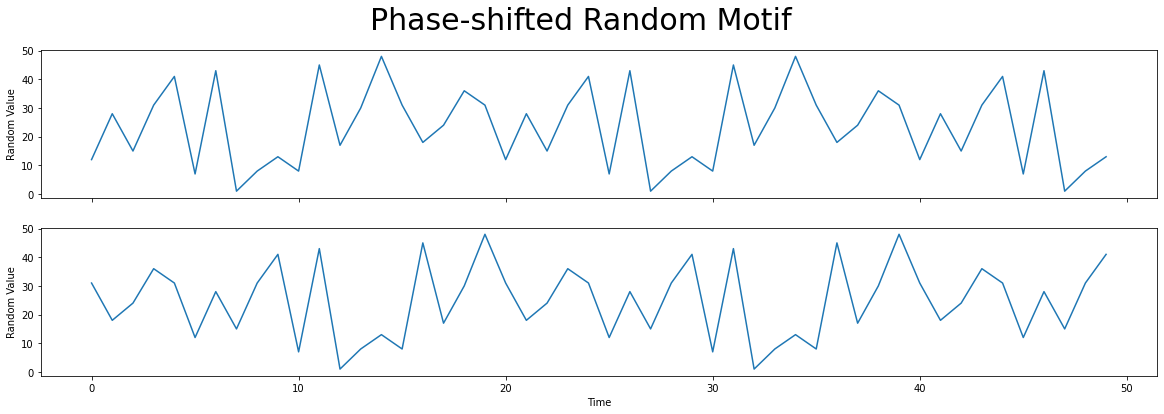

In [2]:
motif = np.floor(np.random.rand(20) * 50)
base = np.tile(motif, 5) # generates a longer sequence to choose two phase-shifted subsequences from

t_1 = base[:50]
t_2 = base[15:65]

plt.style.use(mplstyle_url)

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.2})
plt.suptitle('Phase-shifted Random Motif', fontsize='30')

axs[1].set_xlabel('Time')
axs[0].set_ylabel('Random Value')
axs[1].set_ylabel('Random Value')

axs[0].plot(t_1)
axs[1].plot(t_2)

euc_dist = np.linalg.norm(t_1 - t_2)
mp_dist = stumpy.mpdist(t_1, t_2, 30, percentage=0.05)

print("Euclidean Distance: {:.2f}".format(euc_dist))
print("MPdist: {:.2f}".format(mp_dist))

## Loading the data

We load the data from the [companion website](https://sites.google.com/site/mpdistinfo) of the MPdist paper as numpy arrays. The dataset is for handwriting data for some common American names.

In [3]:
context = ssl.SSLContext()  # Ignore SSL certificate verification for simplicity

fzip = ZipFile(io.BytesIO(urlopen("https://sites.google.com/site/mpdistinfo/home/words_dendrogram.zip?attredirects=0&d=1").read()))
mat = fzip.extract("words_dendrogram/LisaBeth/MaryBethAnhLisa_data.mat")
raw_data = loadmat(mat)['XSsY4']

# The order in which we want the time series to be displayed
ordered_names = ["Mary", "Anne", "Maryanne", "Lisa", "Beth", "Lisabeth"]

# The data for the time series themselves
data = {}
for i in range(raw_data[0].shape[0]):
    name = raw_data[1][i][0].replace("nh", "nne") # for some reason "nne" seems to be replaced by "nh" in the names
    data[name] = raw_data[0][i].flatten().astype(float)    

# Compute rough offsets so that the different names can be aligned visually 
offset_idx = {}
for name in ordered_names:
    idx = np.arange(0, data[name].shape[0])
    if name == 'Anne':
        idx += data['Maryanne'].shape[0] - data['Anne'].shape[0]
    elif name == 'Beth':
        idx += data['Lisabeth'].shape[0] - data['Beth'].shape[0]
    offset_idx[name] = idx

We then plot these time series. Each time series corresponds to a single name indicated on the right. The Y-axis of the plot represents the vertical position of the pen over time as the names are written out in cursive form. The time series are aligned so that the similarities between parts of the names can be seen better. For instance, Anne and Maryanne shares the last three letters "nne" (comparison is case-sensitive )

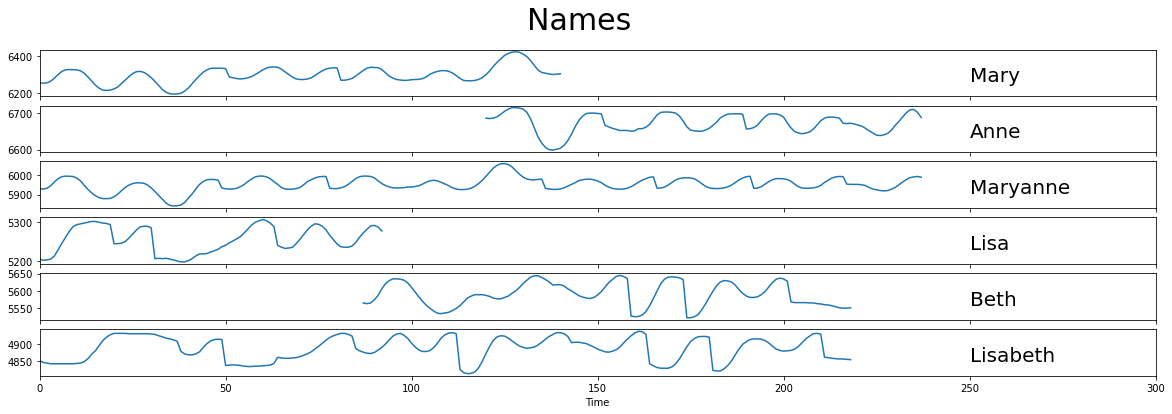

In [4]:
plt.style.use(mplstyle_url)

fig, axs = plt.subplots(len(data), sharex=True, gridspec_kw={'hspace': 0.2})
plt.suptitle('Names', fontsize='30')

axs[-1].set_xlabel("Time")
for i, name in enumerate(ordered_names):
    ymax = data[name].max()
    yrange = data[name].ptp()
    axs[i].set_xlim(0, 300)
    axs[i].plot(offset_idx[name], data[name])
    axs[i].text(250, ymax - 0.7 * yrange, name, color="black", fontsize=20)


## Clustering the Series

A cluster of different time series is supposed to group together time series that are more similar than others. A hierarchical cluster generalizes this notion by allowing groups to be made up of other groups. In this case, we naturally expect the time series for Anne, Mary and Maryanne to be in one cluster while those for Lisa, Beth and Lisabeth to be in a separate cluster due to them sharing part of the names.  

In order to begin clustering the series, we first compute the distance matrices. Entry (i, j) in a distance matrix corresponds to the distance between time series i and j under some measure. We first write a function for computing the distance matrix and a function to cluster the time series and plot them as a dendrogram.

In [5]:
def compute_distance_matrix(distance_function):
    distance_matrix = np.zeros((len(data),len(data)))

    for i, name1 in enumerate(ordered_names):
        for j, name2 in enumerate(ordered_names):
            if not name2 == name1:
                distance_matrix[i, j] = distance_function(data[name1], data[name2])
    return distance_matrix

In [6]:
# Clusters the data and plots it from distance matrix
def plot_cluster(distance_matrix):
    linked = linkage(squareform(distance_matrix), 'complete') 

    fig = plt.figure(figsize=(15, 12))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)


    ax = plt.Subplot(fig, outer[1])

    x = dendrogram(linked,
                orientation='right',
                labels=ordered_names,
                distance_sort='descending',
                show_leaf_counts=False,
                ax=ax)
    fig.add_subplot(ax)
    inner = gridspec.GridSpecFromSubplotSpec(len(data), 1, subplot_spec=outer[0],
                                                 wspace=0.1, hspace=0.1)
    
    for i, name in enumerate(x['ivl'][::-1]):
        ax = plt.Subplot(fig, inner[i])
        ax.set_xlim(0, 250)
        fig.add_subplot(ax)

        ax.axis("off")
        ax.plot(offset_idx[name], data[name])

    plt.show()

First we attempt clustering the time series under Euclidean distance. However, we immediately run into the issue of different time series having different lengths. This is because Euclidean distance requires that the points have the same dimensionality. In order to get around this, we shrink the longer time series to match the length of the shorter. We also z-normalize both of the time series as they start off at arbitrary Y position.

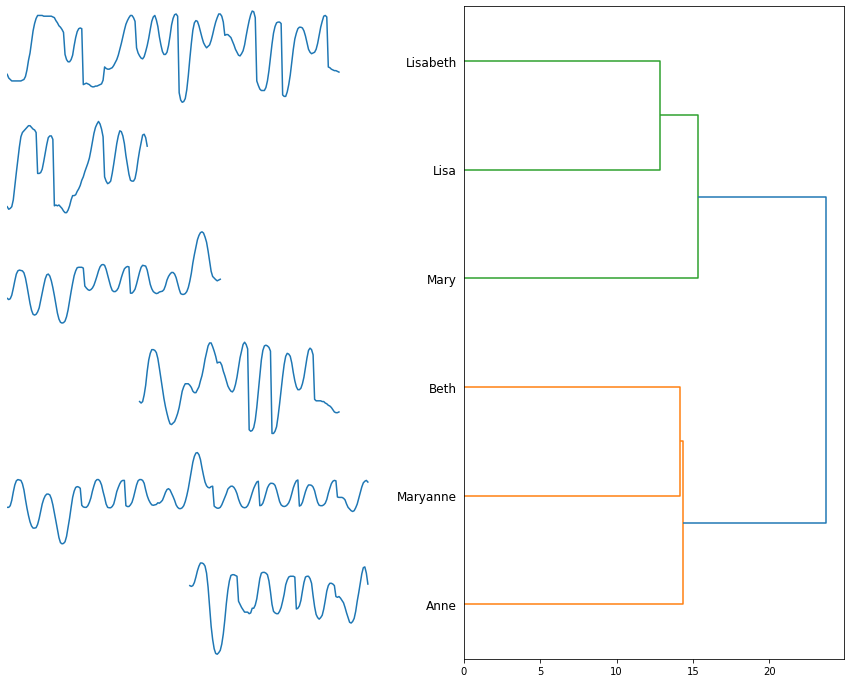

In [7]:
def shrink_ts(x, n):
    idx = np.ceil(np.arange(n) * x.shape[0]/n).astype(np.int64)
    return x[idx]

def euclidean_dist(x, y):
    if x.shape[0] > y.shape[0]:
        x = shrink_ts(x, y.shape[0])
    else:
        y = shrink_ts(y, x.shape[0])
    x = (x - x.mean())/x.std()
    y = (y - y.mean())/y.std()
    return np.linalg.norm(x - y)

euclidean_distance_matrix = compute_distance_matrix(euclidean_dist)
plot_cluster(euclidean_distance_matrix)

As we can see, the results are contrary to our expectation. For instance, Maryanne is in the same broad cluster as Beth whereas Lisabeth is in the same broad cluster as Mary - neither of which makes much sense.

Now, we contast this result with that of MPdist. We compute MPdist by simply calling `stumpy.mpdist` with the two time series, a window length of `30` and a threshold of `0.05`.

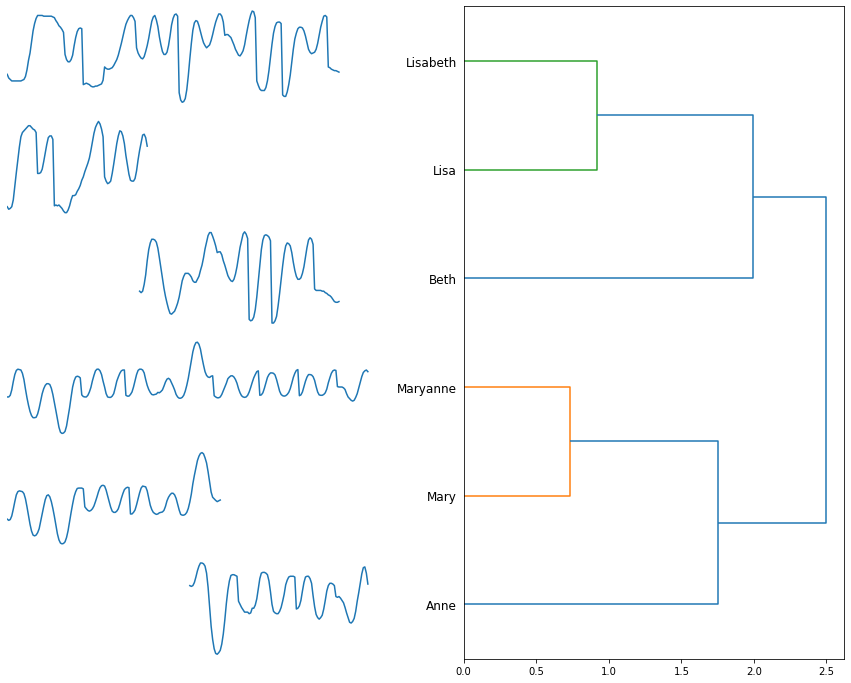

In [8]:
def mpdist(x, y):
    return stumpy.mpdist(x, y, 30, percentage=0.05)
mp_distance_matrix = compute_distance_matrix(mpdist)
plot_cluster(mp_distance_matrix)

This is precisely the result we expected to get initially! The reason why MPdist gives the expected result and Euclidean distance fails is because Euclidean distance compares the whole time series at once whereas MPdist compares the subsequences. Moreover, one of the time series is first distorted to equalize their lengths in order to compute the Euclidean distance.

A careful observation reveals that the hierarchical clusters slightly deviate from the original figures from the paper. For MPdist, this is because the code which generated the original figure used 0.5 as its threshold instead of 0.05 (as explained in the [supporting website](https://sites.google.com/site/mpdistinfo/)). Nevertheless, the three names (Lisa, Beth and Lisabeth) are still within the same large cluster. For Euclidean distance, this is likely due to a different method for shrinking the time series. Again, there is only a minor difference - Lisa and Beth are swapped. 